# Demo for unsupervised Mean-difference Maximization for the Hübner datasets

First we can set some parameters. For now, let's keep the default values in.

In [1]:
# These parameters correspond to the best (on average) performance
# Here you can choose which settings you want to use.
# You can experiment a bit to see how UMM performance deterioates, e.g.,
# with worse covariance estimation ("shrink" instead of "toep"), or when
# discarding all information from previous trials ("curr" for both: cov_data and meanreg_method)

dset = "LLP"  # "LLP" Dataset or "Mix" Dataset
cov_data = "cumu"  # "curr": use only one trial for covariance calculation "cumu": use current and past trials
covreg_method = "toep"  # "shrink": use ledoit-wolf shrinkage  "toep": use block-toeplitz approach (see paper)
meanreg_method = "conf"  # "conf": confidence-based mean aggregation, "opti": optimistic mean estimation, # "curr": only current trial for mean estimation

# Choose a subset of subjects so the evaluation is quicker (and your disk space free-er :-) )
# Using subject 8 of LLP, as here UMM makes one mistake in the first block
# Set to none if you want to select all subjects of the dataset (disk space needed approx. 750MB per subject)
sel_subs = [8]

Now we import all the packages we need and set up some metadata that is needed for UMM, e.g., a binary vector containing the currently highlighted letters.

In [2]:
import time

import numpy as np
import pandas as pd
from toeplitzlda.classification import EpochsVectorizer

from umm_demo.classification import UnsupervisedMeanMaximization
from toeplitzlda.classification.covariance import ToepTapLW

from moabb.paradigms import P300
from pathlib import Path

from umm_demo.usup_replay.visual_speller import (
    NUMBER_TO_LETTER_DICT,
    VisualMatrixSpellerMixDataset,
    VisualMatrixSpellerLLPDataset,
)

import mne

from copy import deepcopy

spellable = [s for s in NUMBER_TO_LETTER_DICT.values() if s != "#"]
spellable[spellable.index(" ")] = "_"
number_to_letter = {num: s for num, s in enumerate(spellable)}

# These estimation methods are available
COV_DATA = ["cumu", "curr"]
COVREG_METHOD = ["toep", "shrink"]
MEANREG_METHOD = ["conf", "opti", "curr"]
DATASETS = ["Mix", "LLP"]

if dset == "Mix":
    n_letters = 35
    # Note that Letters 36-70 in MIX are not used, as free spelling was done.
    # Ground truth for these spelled letters is not available.
    true_sentence = "FRANZY_JAGT_IM_TAXI_QUER_DURCH_DAS_"
    subjects = list(range(1, 13)) if sel_subs is None else sel_subs
    # subjects = list(range(1, 2))
    dataset_class = VisualMatrixSpellerMixDataset
    dcode = "mix"
elif dset == "LLP":
    n_letters = 63
    # n_letters = 21
    true_sentence = "FRANZY_JAGT_IM_KOMPLETT_VERWAHRLOSTEN_TAXI_QUER_DURCH_FREIBURG."
    subjects = list(range(1, 14)) if sel_subs is None else sel_subs
    # subjects = list(range(1, 13))
    dataset_class = VisualMatrixSpellerLLPDataset
    dcode = "llp"
else:
    raise ValueError(f"Dataset {dset} unknown")


def create_onehot_series(letter_index, letters):
    row = dict()
    row["LetterIndex"] = letter_index
    for s in spellable:
        row[f"L_{s}"] = s in letters
    row["SeqTarget"] = true_sentence[letter_index - 1] in letters
    return row


mne.set_log_level("ERROR")

cache_dir = Path.home() / "cache"
cache_dir.mkdir(exist_ok=True)

paradigm = P300(fmin=0.5, fmax=8, resample=40)

forced_reload = False

pars = [(cov_data, covreg_method, meanreg_method)]

verbose = True

print("Evaluating following hyperparameter set:")
print(pars)


Evaluating following hyperparameter set:
[('cumu', 'toep', 'conf')]


### Running the benchmark

**Note**: If you are running this for the first time, this code will download all the EEG data for each subject / dataset. For the Hübner Dataset, each subject will occupy approx. 650MB disk space. Additionally, the preprocessed EEG data will be cached (at `~/cache`, around 70MB per subject), to save time on future invocations / if you want to evaluate different UMM parameter combinations. WARNING: if you change pre-processing parameters (e.g. filtering) make sure to empty the cache or use `forced_reload=True`.

Depending on your internet connection / processing power, the very first run (with downloading data, preprocessing etc.) of every subject may take up to 10 minutes. This cell looks large, but most of the code concerns iterating over all necessary entities and logging some stats for exploration / visualization, etc.

In [3]:
# Iterate over all selected parameter combinations
for pari, (cov_data, covreg_method, meanreg_method) in enumerate(pars):
    row = dict()
    rows = list()
    all_gts = list()

    row["cov_data"] = cov_data
    row["covreg_method"] = covreg_method
    row["meanreg_method"] = meanreg_method

    print(
        f"Evaluating parameter set ({pari+1}/{len(pars)}):\n {cov_data=}\n {covreg_method=}\n "
        f"{meanreg_method=}\n"
    )
    # Iterate over all selected subjects
    for sub in subjects:
        print(f"Subject {sub}")
        row["subject"] = sub
        ds = dataset_class()
        ds.subject_list = [sub]
        
        # Iterate over each experimental block of each subject (i.e, each sentence to spell)
        for block in range(1, 4):
            e_file = cache_dir / f"{dcode}_sub_{sub}_block_{block}-epo.fif"
            if e_file.exists() and not forced_reload:
                print(" Loading cached.")
                epochs = mne.read_epochs(e_file)
            else:
                print(" Loading and preprocessing. Also converting letter events to letter meta.")
                try:
                    epochs, _ = ds.load_epochs(block_nrs=[block], fband=[0.5, 8], sampling_rate=40)
                except ValueError:
                    print("Could not load block raw data. Skipping.")
                    continue
                if dcode == "mix":
                    select_letters = [f"Letter_{i+1}" for i in range(n_letters)]
                    epochs = epochs[select_letters]
                md = pd.DataFrame(columns=["LetterIndex", *spellable])
                meta_rows = list()
                # Converting letter events to letter metadata
                for i in range(len(epochs)):
                    evs = [k.split("/") for k in epochs[i].event_id.keys()][0]
                    letter_idx = int("".join([s for s in evs[0] if s.isdigit()]))
                    letters = [l for l in evs if len(l) == 1 and evs != "#"]
                    if " " in letters:
                        letters[letters.index(" ")] = "_"
                    meta_row = create_onehot_series(letter_idx, letters)
                    meta_rows.append(meta_row)

                meta_df = pd.DataFrame.from_records(meta_rows)
                epochs.metadata = meta_df
                if not forced_reload:
                    epochs.save(e_file)

            row["block"] = block
            if verbose:
                print(f" Block {block}")

            gt = list()
            target_highlightings = np.empty((n_letters)) - np.inf
            for li in epochs.metadata.LetterIndex.unique():
                e = epochs[f"LetterIndex == {li}"]
                counts = e["Target"].metadata.sum()
                counts = counts.drop(["LetterIndex", "SeqTarget"])
                s = counts.argmax()
                target_highlightings[li - 1] = counts[s]
                letter = number_to_letter[s]
                gt.append(letter)
            gt_str = "".join(gt)
            row["valid_session"] = True
            if gt_str != true_sentence:
                print(
                    f"WARNING Subject {sub} in block {block} do not produce supposed ground "
                    f"truth."
                )
                print(f"Decoded sentence: {gt_str}")
                row["valid_session"] = False

            # fmt: off
            channel_set_31 = ["Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2", "F7", "F8", "T7", "T8", "P7", "P8", "Fz", "Cz", "Pz", "FC1", "FC2", "CP1", "CP2", "FC5", "FC6", "CP5", "CP6", "F9", "F10", "P9", "P10"]
            # fmt: on
            assert len(channel_set_31) == 31

            epochs.pick_channels(channel_set_31)
            row["channels"] = "_".join(epochs.ch_names)
            epo_copy = epochs.copy()
            epo_copy.drop_bad(dict(eeg=100e-6))
            n_drops = len(epochs) - len(epo_copy)
            if verbose:
                print(f" Would have rejected {n_drops} epochs at 100uv minmax")
            del epo_copy
            row["n_drops"] = n_drops
            
            # Same range as Huebner paper, but without jumping means
            evec = EpochsVectorizer(select_ival=[0.05, 0.7])
            evec.transform(epochs[0])
            n_times = len(evec.times_)
            n_channels = len(epochs.ch_names)
            row["n_channels"] = n_channels
            row["n_times"] = n_times
            
            collected_confs = np.zeros((n_letters))

            last_learning_letter = np.inf
            row["last_learning_letter"] = last_learning_letter

            use_only_ledoitwolf = covreg_method == "shrink"
            use_cumulative_cov = cov_data == "cumu"

            suffix = f"covdata_{cov_data}_covreg_{covreg_method}_meanreg_{meanreg_method}"

            cumu_trial_X_no_trialmean = None

            ce = ToepTapLW(n_channels=n_channels, only_lw=use_only_ledoitwolf)
            umm = UnsupervisedMeanMaximization(
                cov_estimator=ce,
                # mean_reg_method="curr"
                mean_reg_method=meanreg_method,
                class_labels=spellable,
                use_cumu_cov=use_cumulative_cov,
                # eucl_dist=True,
            )
            if verbose:
                print("UMM initialization:")
                print(str(umm))

            for let_i, li in enumerate(epochs.metadata.LetterIndex.unique()):
                letter_time = time.time()
                epo_current_trial = epochs[f"LetterIndex == {li}"]
                row["nth_letter"] = li
                row["train_phase"] = li <= 33
                row["num_epos"] = len(epo_current_trial)
                row["target_highlightings"] = target_highlightings[let_i]
                epo_current_trial.reset_drop_log_selection()
                current_trial_X = evec.transform(epo_current_trial)

                t_assignment_matrix = np.zeros((len(epo_current_trial), len(spellable)))
                nt_assignment_matrix = np.zeros((len(epo_current_trial), len(spellable)))

                # In this dataset, stimulation sequences were identical in each letter
                # Could replace this with loaded data?
                for si, s in enumerate(spellable):
                    # MNE does not allow all column names?
                    t_epo = epo_current_trial[epo_current_trial.metadata[f"L_{s}"]]
                    nt_idx = np.setxor1d(t_epo.selection, epo_current_trial.selection)
                    # Factors: 1/class_size
                    num_t_epos = len(t_epo)
                    num_n_epos = len(nt_idx)
                    if num_t_epos > 0:
                        t_assignment_matrix[t_epo.selection, si] = 1 / num_t_epos
                    if num_n_epos > 0:
                        nt_assignment_matrix[nt_idx, si] = 1 / num_n_epos
                # MAIN UMM USAGE
                # set up y as expected by UMM
                y = np.vstack([nt_assignment_matrix[None, :], t_assignment_matrix[None, :]])
                umm.fit(current_trial_X, y)
                pred_letter = umm.predict()
                stats = umm.last_fit_stats
                cout = umm.lda.decision_function(current_trial_X)

                # compatibility store this twice
                row["t_to_nt_runnerup"] = stats["confidence"]
                row["confidence"] = stats["confidence"]
                row["cur_confidence"] = stats["cur_confidence"]
                row["covariance_inversion_duration"] = stats["covariance_inversion_duration"]
                row["fit_duration"] = stats["fit_duration"]

                true_letter = true_sentence[let_i]
                letter_order = np.array(spellable)[np.argsort(umm.distances_)][::-1]
                letter_distance = np.where(letter_order == true_letter)[0][0]
                row["distance_to_true_letter"] = letter_distance
                row["decoded_letter"] = pred_letter
                row["true_letter"] = true_letter
                correct = true_letter == pred_letter
                row["correct"] = correct
                row["letter_duration"] = time.time() - letter_time

                if verbose:
                    print(f"  {li}, true: '{true_letter}'  pred: '{pred_letter}'. Confidence: {stats['confidence']}")
                    if not correct:
                        print(f"  off by: {letter_distance}")

                rows.append(deepcopy(row))

            results_df = pd.DataFrame.from_records(rows)
            results_df.to_csv(Path.home() / f"results_{dcode}_{suffix}.csv.gz", compression="gzip")

        print(f"\nSome Stats")
        print(results_df.groupby(["subject", "block"]).mean().n_drops)
        print(f"\nFinal evaluation")
        print(f"Wrong letters: {np.sum(~results_df.correct)}")


Evaluating parameter set (1/1):
 cov_data='cumu'
 covreg_method='toep'
 meanreg_method='conf'

Subject 8
 Loading cached.
 Block 1
 Would have rejected 33 epochs at 100uv minmax
UMM initialization:
UnsupervisedMeanMaximization(class_labels=['A', 'B', 'C', 'D', 'E', 'F', 'G',
                                           'H', 'I', 'J', 'K', 'L', 'M', 'N',
                                           'O', 'P', 'Q', 'R', 'S', 'T', 'U',
                                           'V', 'W', 'X', 'Y', 'Z', '_', '.',
                                           ',', '!', ...],
                             cov_estimator=ToepTapLW(n_channels=31),
                             mean_reg_method='conf')
  1, true: 'F'  pred: 'F'. Confidence: 0.6140042102273127
  2, true: 'R'  pred: 'R'. Confidence: 3.2728498447870678
  3, true: 'A'  pred: 'A'. Confidence: 4.374640667410816
  4, true: 'N'  pred: 'N'. Confidence: 1.2495639760426713
  5, true: 'Z'  pred: 'Z'. Confidence: 1.8586078656651712
  6, true: 'Y'  pred

  57, true: 'E'  pred: 'E'. Confidence: 3.0255901053788423
  58, true: 'I'  pred: 'I'. Confidence: 4.269704947879055
  59, true: 'B'  pred: 'B'. Confidence: 2.8994342792446437
  60, true: 'U'  pred: 'U'. Confidence: 2.4491829435619263
  61, true: 'R'  pred: 'R'. Confidence: 4.52145365012704
  62, true: 'G'  pred: 'G'. Confidence: 2.5612731308955334
  63, true: '.'  pred: '.'. Confidence: 3.426308839939594
 Loading cached.
 Block 3
 Would have rejected 101 epochs at 100uv minmax
UMM initialization:
UnsupervisedMeanMaximization(class_labels=['A', 'B', 'C', 'D', 'E', 'F', 'G',
                                           'H', 'I', 'J', 'K', 'L', 'M', 'N',
                                           'O', 'P', 'Q', 'R', 'S', 'T', 'U',
                                           'V', 'W', 'X', 'Y', 'Z', '_', '.',
                                           ',', '!', ...],
                             cov_estimator=ToepTapLW(n_channels=31),
                             mean_reg_method='conf')
  1,

/tmp/ipykernel_1234958/2698085083.py:189: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(results_df.groupby(["subject", "block"]).mean().n_drops)


Finally lets do some visualization. Note the following cell works only when only one hyperparameter set is selected, as we did at the start.

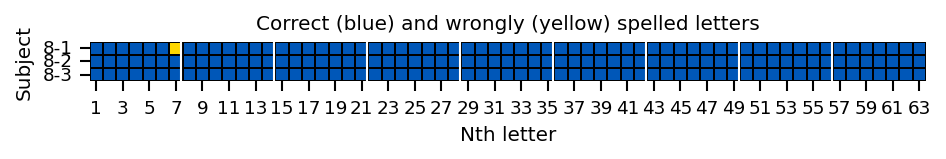

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
plt.rcParams["figure.dpi"] = 150
df = results_df

cm = sns.color_palette(["#FFD700", "#0057B8"], as_cmap=True)

n_letters = df.nth_letter.max()
vline_pos = range(7, n_letters, 7)

hm_df = df[["subject", "block", "nth_letter", "correct"]]
hm_df = hm_df.pivot(index=["subject", "block"], columns="nth_letter", values="correct")
hm_df = hm_df.fillna(0.5).astype(float)
# axes = axes.ravel()
g = sns.heatmap(
    hm_df,
    #ax=axes,
    square=True,
    vmin=0,
    vmax=1,
    cbar=None,
    cmap=cm,
    linewidths=0.05,
    linecolor="black",
)
axes = g.axes
[axes.axvline(l - 0.1, color="white", linewidth=1) for l in vline_pos]


axes.set_title("Correct (blue) and wrongly (yellow) spelled letters")
axes.set_xlabel("Nth letter")
axes.set_ylabel("Subject")
plt.tight_layout()